**IMPORTING THE NECESSARY LIBRARIES**

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold


In [ ]:
#IMPORTING THE DATA
df=pd.read_csv('/content/email_spam.csv')
df.head()



,title,text,type
0,?? the secrets to SUCCESS,"Hi James,\n\nHave you claim your complimentary...",spam
1,?? You Earned 500 GCLoot Points,"\nalt_text\nCongratulations, you just earned\n...",not spam
2,?? Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420!\n ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello,\n \nThank you for contacting the Virtua...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal,\n\nToday's newsletter is ...",spam


**A. NECESSARY PREPROCESSING STEPS**

In [ ]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 title    0
text     0
type     0
dtype: int64


In [ ]:
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()

# Check the shape after dropping duplicates
print("Shape after dropping duplicates:", df.shape)


Number of duplicate rows: 1
Shape after dropping duplicates: (83, 3)


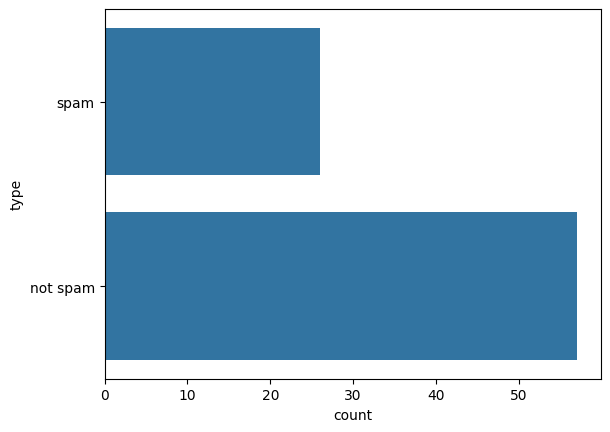

In [ ]:
# Distribution of target variable
sns.countplot(df['type'])
plt.show()

In [ ]:
# Encode categorical columns using LabelEncoder
label_encoder = LabelEncoder()

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
        df[col] = label_encoder.fit_transform(df[col])

df.head()

,title,text,type
0,3,41,1
1,1,3,0
2,2,36,0
3,74,35,0
4,0,38,1


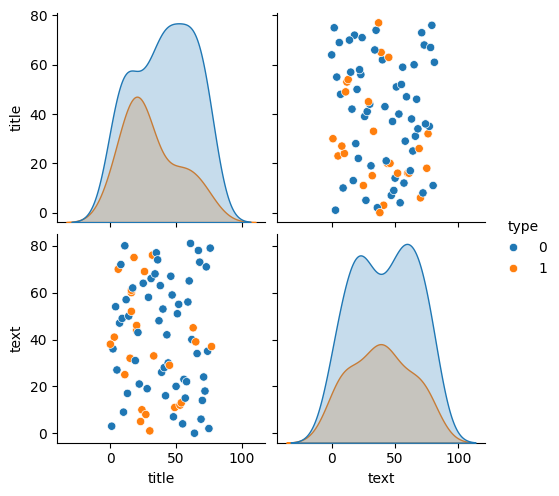

In [ ]:
# Pairplot for relationship between features
sns.pairplot(df, hue='type')
plt.show()

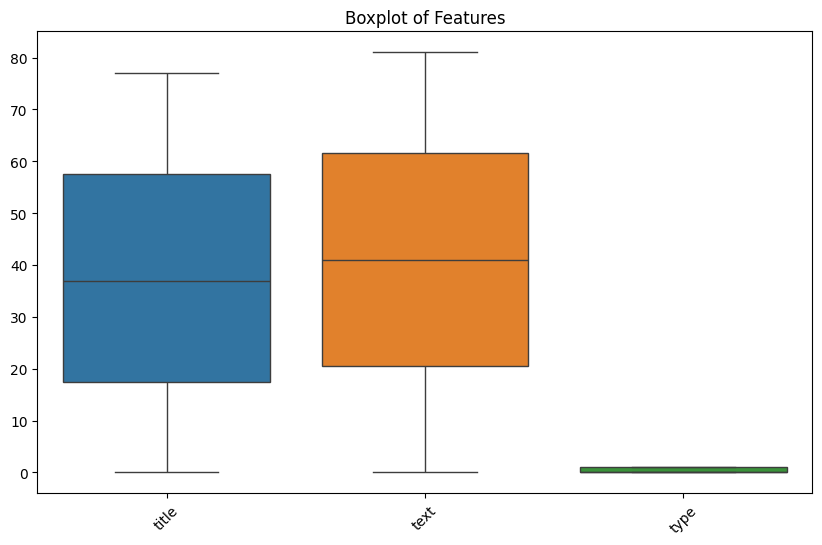

In [ ]:
# Check for outliers using boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title("Boxplot of Features")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Define columns to check for outliers
columns_to_check = ['title', 'text', 'type']

# Calculate Z-scores for each column
z_scores = np.abs((df[columns_to_check] - df[columns_to_check].mean()) / df[columns_to_check].std())

# Filter rows where any Z-score is greater than 3
outliers = df[(z_scores > 3).any(axis=1)]

# Remove outliers
data_no_outliers = df.drop(outliers.index)

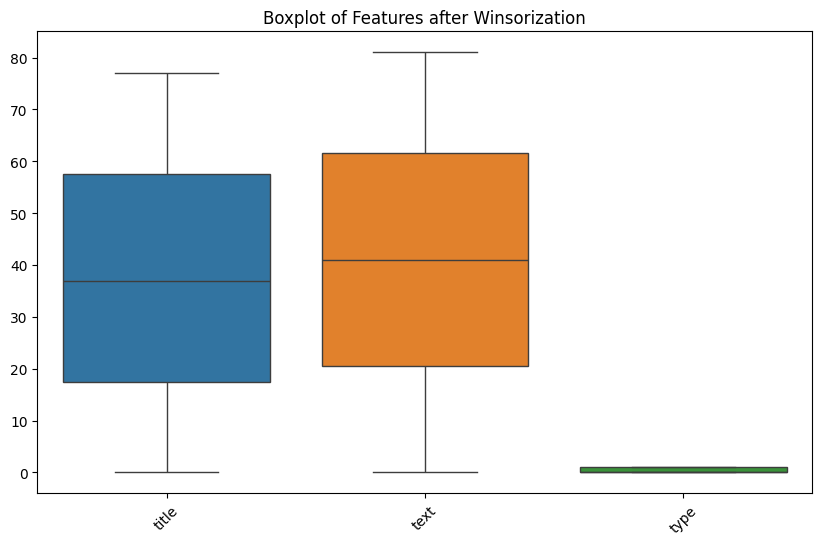

In [ ]:
# Visualize again after winsorization
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_no_outliers)
plt.title("Boxplot of Features after Winsorization")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Declare feature vector (X) & target vector (Y)
X = data_no_outliers.drop('type', axis=1)
Y = data_no_outliers['type']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


**B. INTITIALIZING AND FITTING THE MODEL**

In [ ]:

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Run SVM with default parameters
svm_model = SVC(C=1.0, kernel='rbf', gamma='auto', probability=True)  # Enable probability estimates
svm_model.fit(X_train_scaled, Y_train)



SVC(gamma='auto', probability=True)

In [ ]:
# Predicting on test set
Y_pred = svm_model.predict(X_test_scaled)
print("Predictions:", Y_pred)

Predictions: [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


**ACCURACY**

In [ ]:
# Calculate accuracy score
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.6470588235294118


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[10  1]
 [ 5  1]]


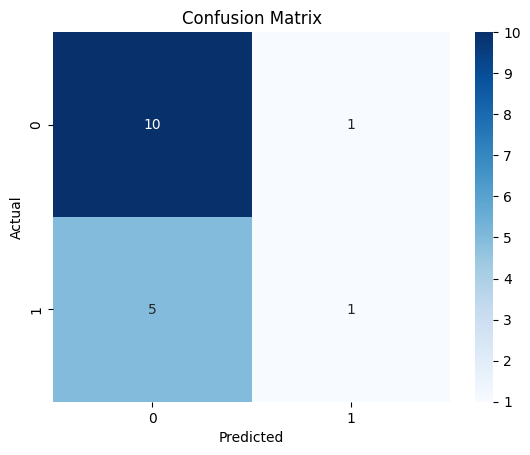

In [ ]:
# Visualize confusion matrix with seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
class_report = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.91      0.77        11
           1       0.50      0.17      0.25         6

    accuracy                           0.65        17
   macro avg       0.58      0.54      0.51        17
weighted avg       0.61      0.65      0.59        17



In [ ]:
# Convert target labels to binary format
Y_test_binary = label_binarize(Y_test, classes=[0, 1, 2])

# Calculate decision scores for each class
# Y_scores was a 1D array, it needs to be 2D for the slicing to work
Y_scores = svm_model.decision_function(X_test_scaled)

# Compute ROC curve and ROC-AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    # Check if both classes are present
    if len(np.unique(Y_test_binary[:, i])) == 2:
        fpr[i], tpr[i], _ = roc_curve(Y_test_binary[:, i], Y_scores) # Removed second index since Y_scores is 1D
        roc_auc[i] = roc_auc_score(Y_test_binary[:, i], Y_scores)
        print("ROC-AUC Score for Class {}:".format(i), roc_auc[i]*100)
    else:
        print("ROC AUC score not defined for class {} due to only one class present.".format(i))

ROC-AUC Score for Class 0: 66.66666666666667
ROC-AUC Score for Class 1: 33.33333333333333
ROC AUC score not defined for class 2 due to only one class present.


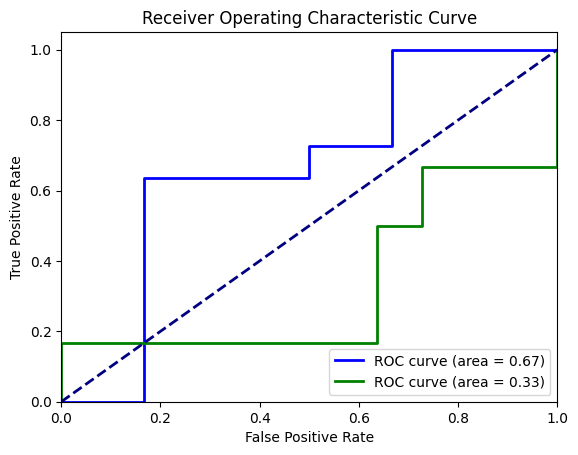

In [ ]:
# Plot ROC curves
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(3), colors):
    if i in fpr:  # Check if ROC curve was calculated for this class
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate sensitivity and specificity for each class
sensitivity = dict()
specificity = dict()
for i in range(3):
    # Check if both classes are present
    if len(np.unique(Y_test_binary[:, i])) == 2:
        TP = np.sum((Y_test_binary[:, i] == 1) & (Y_scores > 0)) # Removed second index from Y_scores
        TN = np.sum((Y_test_binary[:, i] == 0) & (Y_scores <= 0)) # Removed second index from Y_scores
        FP = np.sum((Y_test_binary[:, i] == 0) & (Y_scores > 0)) # Removed second index from Y_scores
        FN = np.sum((Y_test_binary[:, i] == 1) & (Y_scores <= 0)) # Removed second index from Y_scores

        sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

        print("Class {}: Sensitivity = {:.2f}, Specificity = {:.2f}".format(i, sensitivity[i], specificity[i]))

Class 0: Sensitivity = 0.09, Specificity = 0.83
Class 1: Sensitivity = 0.17, Specificity = 0.91


**PLOTTING**

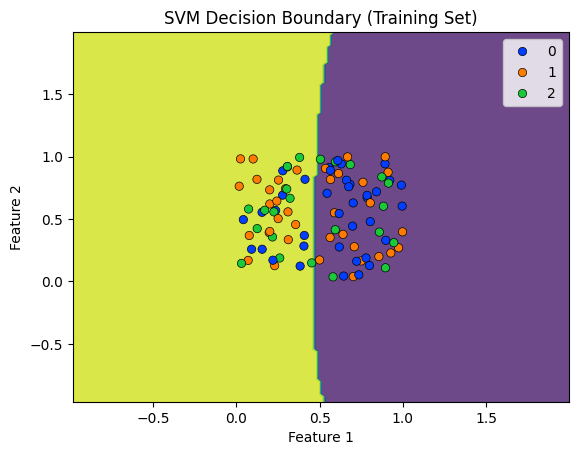

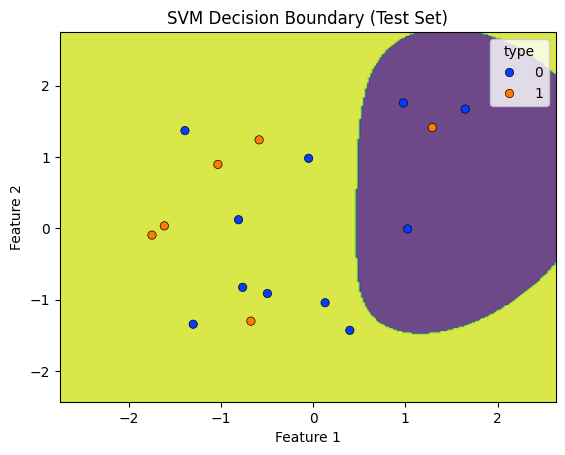

In [ ]:
def plot_decision_boundaries(X, y, model, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='bright', edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# For demonstration, use the first two features
X_train_2d = X_train_scaled[:, :2]
X_test_2d = X_test_scaled[:, :2]

# Train the model on the 2D data
svm_model_2d = SVC(C=1.0, kernel='rbf', gamma='auto')
svm_model_2d.fit(X_train_2d, Y_train)

# Plot the decision boundary
plot_decision_boundaries(X_train_2d, Y_train, svm_model_2d, title="SVM Decision Boundary (Training Set)")

# Plot the decision boundary on the test set
plot_decision_boundaries(X_test_2d, Y_test, svm_model_2d, title="SVM Decision Boundary (Test Set)")

**C. COMPARING WITH LOGISTIC REGRESSION**

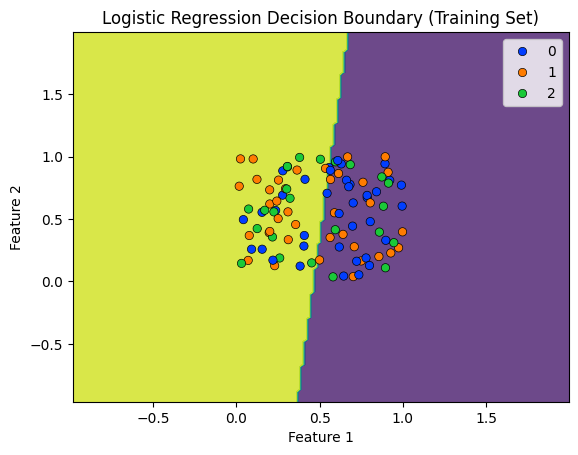

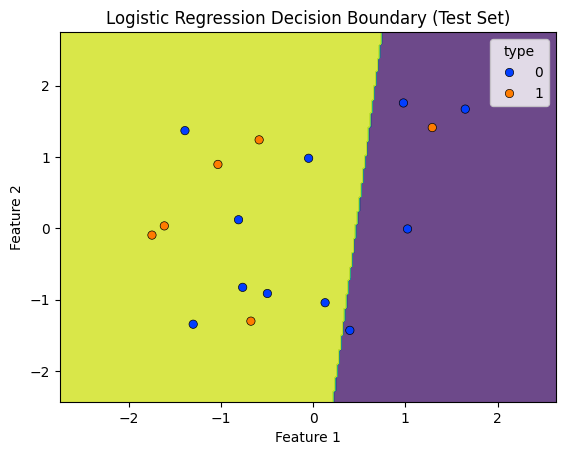

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and fit Logistic Regression model
# Fit the model on the 2D data to be consistent
logreg_model = LogisticRegression()
logreg_model.fit(X_train_2d, Y_train)

# Plot decision boundaries for Logistic Regression
plot_decision_boundaries(X_train_2d, Y_train, logreg_model, title="Logistic Regression Decision Boundary (Training Set)")
plot_decision_boundaries(X_test_2d, Y_test, logreg_model, title="Logistic Regression Decision Boundary (Test Set)")

**D. K_FOLD CROSS VALIDATION AND HYPERPARAMETER TUNING**

In [ ]:
best_params = grid_search.best_params_

In [ ]:
best_svm = SVC(**best_params)
best_svm.fit(X_train_scaled, Y_train)

SVC(C=0.1, kernel='linear')

In [ ]:
# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-validation
for train_index, test_index in skf.split(X_train_scaled, Y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    # Use .iloc to index based on integer position instead of label
    Y_train_fold, Y_val_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    # Train SVM model
    svm_model.fit(X_train_fold, Y_train_fold)

    # Calculate accuracy on validation set
    acc = svm_model.score(X_val_fold, Y_val_fold)
    print("Validation Accuracy:", acc)

# Define the parameters grid
param_grid = {'C': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly'],
              'gamma': ['scale', 'auto']}

# Perform Grid Search
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
grid_search.fit(X_train_scaled, Y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

Validation Accuracy: 0.6428571428571429
Validation Accuracy: 0.7692307692307693
Validation Accuracy: 0.7692307692307693
Validation Accuracy: 0.7692307692307693
Validation Accuracy: 0.6923076923076923
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END 